Integrated spectral flux for a BlackBody:

\begin{equation}
BB(\lambda, T_{eff}) = \dfrac{2hc^2}{\lambda^5} \dfrac{1}{e^{{h c}/(\lambda k_b T_{eff})} - 1} \qquad [\text{J}\,s^{-1}\text{sr}^{-1}m^{-3}]
\end{equation}
Given $t_{eff}=\mathcal{T}\,;\,\lambda=\Lambda$, The energy per second is: \rightarrow
$$ BB(\Lambda,\mathcal{T})\cdot A_{eff} \cdot \Omega \equiv E_{BB} \qquad [\text{J}s^{-1}m^{-1}] $$
where:
- $\Omega$ is the total solid angle $\bigg(\dfrac{A_{eff}}{R^2}\bigg)$ $\rightarrow$ $2\pi\big(1-\cos{\frac{\alpha}{2}}\big)$ for a cone (α = parallax ?)
- $A_{eff}$ is the total collecting area

The photon energy is:

$$ E_\gamma = \dfrac{hc}{\lambda} $$

so that, the photon number emitted per unit time and unit area, from the surface ($\pi$) is:

$$ P_\lambda(T_{eff}) = \dfrac{\pi BB(\lambda,T_{eff})}{E_\gamma} = \dfrac{2\pi c}{\lambda^4}\dfrac{1}{e^{{h c}/(\lambda k_b T_{eff})} - 1}  \quad [\text{photons}\,s^{-1}cm^{-2}nm^{-1}]$$

To obtain the **spectral density flux** over a spèecific band, one must integrate:

$$ P(T_{eff}) = \int_{\lambda_1}^{\lambda_2} P_\lambda(T_{eff}) \, d\lambda $$

In [42]:
from astropy import units as u
from astropy.constants import h, c, k_B
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
import numpy as np
from astropy.table import QTable

Gbp = QTable.read("data/gaiaDR3passband.fits")

In [3]:
T_eff = 5778 * u.K
A = 1*(u.erg/(u.cm**2 * u.s * u.AA * u.sr))
bb = BlackBody(temperature=T_eff, scale=A)

In [4]:
wl = 5000 * u.AA
val = bb(wl)

print(f"Black body flux at 5000 A: {val:.2e} (cgs)  ;  {val.to(u.J / (u.m**3 * u.sr * u.s)):.2e} (SI)")

Black body flux at 5000 A: 2.64e+06 erg / (Angstrom s sr cm2) (cgs)  ;  2.64e+13 J / (s sr m3) (SI)


In [5]:
val_SI = val.to(u.J / (u.m**3 * u.sr * u.s))

lambd = wl.to(u.m)
A_eff = 1.45*0.5 * u.m**2

D = (1*u.kpc).to(u.m) # distance

Om = 4*np.pi # (A_eff / D**2) * u.sr 

E_gamma = h*c/lambd

P_BB = val_SI * A_eff * Om / E_gamma

In [6]:
P_BB*lambd*4.42 * u.s

<Quantity 1.33670913e+27 1 / sr>

Photon flux at λ = 500.0 nm: 2.086e+26 1 / (s cm3)


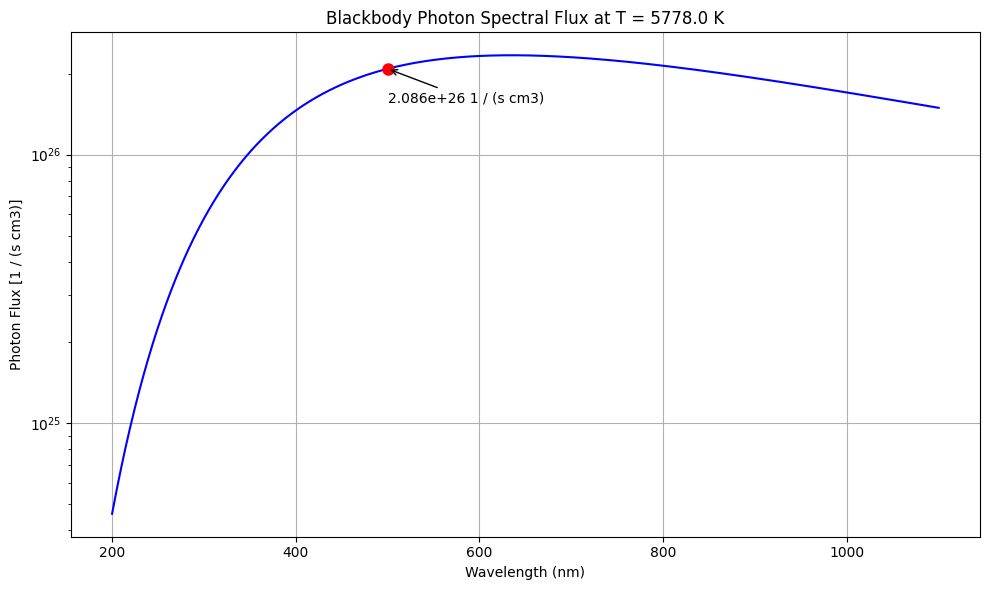

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

def blackbody_photon_flux(wavelength_nm, T_eff):
    """
    Calculate the blackbody photon spectral flux at the stellar surface.
    
    Parameters:
    -----------
    wavelength_nm : float or ndarray
        Wavelength in nanometers
    T_eff : float
        Effective temperature of the star in Kelvin
    
    Returns:
    --------
    flux : float or ndarray
        Photon spectral flux in photons s⁻¹ cm⁻² nm⁻¹
    """
    # Convert wavelength to meters for SI calculation
    wavelength_cm = wavelength_nm.to('cm')  # Convert to meters
    
    c_cm = c.to('cm/s')  # Speed of light in cm/s
    k = k_B      # Boltzmann constant (J/K)
    
    # Calculate the exponent term
    if not isinstance(T_eff, u.Quantity):
        T_eff = T_eff * u.K
    exponent = h*c_cm/(wavelength_cm*k*T_eff)
    
    # Avoid overflow in the exponential
    with np.errstate(over='ignore'):
        # Use expm1 for numerical stability when exponent is small
        denominator = np.expm1(exponent)
    
    # Calculate photon number flux (per m² per m wavelength)
    # This is 2πc/λ⁴ × 1/(e^(hc/λkT)-1)
    photon_flux = (2.0 * np.pi * c_cm) / (wavelength_cm**4) / denominator
    
    return photon_flux

# Example: Calculate and plot photon flux for a Sun-like star (T_eff = 5778 K)

# Set up wavelength array from UV to near-IR (200-1000 nm)
wavelengths = np.linspace(200, 1100, 1100) * u.nm

# Calculate photon flux
solar_T_eff = 5778 *u.K
flux = blackbody_photon_flux(wavelengths, solar_T_eff)

# Plot the result
with quantity_support():
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, flux, 'b-')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(f'Photon Flux [{flux.unit}]')
    plt.title(f'Blackbody Photon Spectral Flux at T = {solar_T_eff}')
    plt.grid(True)

    # Calculate flux at a specific wavelength (e.g., 500 nm)
    specific_wavelength = 500 * u.nm
    specific_flux = blackbody_photon_flux(specific_wavelength, solar_T_eff)
    print(f"Photon flux at λ = {specific_wavelength}: {specific_flux:.3e}")

    # Mark this point on the plot
    plt.plot(specific_wavelength, specific_flux, 'ro', ms=8)
    plt.annotate(f'{specific_flux:.3e}', 
                xy=(specific_wavelength, specific_flux),
                xytext=(specific_wavelength, specific_flux*0.75),
                arrowprops=dict(arrowstyle='->'))

    plt.yscale('log')
    plt.tight_layout()
    plt.show()